# Tappy Keystroke Data with Parkinson’s Patients

Tappy è un'applicazione per la registrazione delle sequenze di battitura.

Nel progetto verrà analizzato un dataset contenente i registri delle sequenze di tasti raccolti da oltre 200 soggetti, con e senza il morbo di Parkinson, che hanno digitato normalmente sul proprio computer per un periodo di settimane o mesi, senza supervisione.

L'analisi si compone di una parte di acquisizione e pulizia dei dati, e di un'altra parte per l'utilizzo di modelli di machine learning, che hanno lo scopo di indicare che l'interazione con la tastiera può essere usata per rilevare particolarità nel movimento delle dita nelle prime fasi del morbo di Parkinson.

Il dataset è stato scaricato dal link https://www.kaggle.com/datasets/valkling/tappy-keystroke-data-with-parkinsons-patients. È suddiviso a sua volta in due dataset: il primo è fornito direttamente dal software Tappy, quindi include dati come tempo di pressione e rilascio dei tasti e movimenti ottenuti dividendo virtualmente la tastiera in una zona di destra e una di sinistra; il secondo contiene informazioni sui pazienti (quali anno di nascita, sesso, e attributi riguardanti il morbo di Parkinson qualora il paziente ne fosse affetto). Tra questi, l'attributo più importante è "Parkinsons", che verrà usata come predizione per la classificazione binaria.

Al dataset è associato un articolo preso dal sito https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0188226#sec008, in cui viene spiegato il significato degli attributi. Da questo paper abbiamo tratto informazioni utili per l'acquisizione dei dati.

### Indice

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.stats import skew, kurtosis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix

### Caricamento dataset
Dopo aver creato due DataFrame a partire dai dati di Kaggle, questi vengono uniti tramite *merge* per creare un DataFrame intero, che sarà il punto di partenza del processamento dei dati.

In [4]:
# Creation of user_df, a DataFrame with informations about Archived Users

users = []

for filepath in glob.iglob('Users/Archived users/*.txt'):
    users.append(filepath[-14:-4])

user_number = len(users)    # number of users

user_df = pd.DataFrame(users, columns = ["Users"])

# Create columns

col_index = []

file = open('Users/Archived users/User_' + str(users[0]) + ".txt")
lines = file.read().split("\n")
ll = len(lines)

for l in range(ll-1):
    sl = lines[l].split(": ", 1)
    col_index.append(sl[0])

# Create values

values_list = []
values = []

for i in range(user_number):
    file = open('Users/Archived users/User_' + str(users[i]) + ".txt")
    lines = file.read().split("\n")
    for l in range(ll-1):
        sl = lines[l].split(": ", 1)
        v = sl[1]
        values.append(v)
    values_list.append(values)
    values = []

# Insert values in user_df

value_df = pd.DataFrame(values_list, columns = col_index)

user_df = pd.concat([user_df, value_df], axis = 1)

# Creation of tappydata_df, a DataFrame with informations about Archived Data

tappydata = []

for filepath in glob.iglob('Data/Tappy Data/*.txt'):
    file = open(filepath)
    lines = file.read().split("\n")
    for l in range(len(lines)-1):
        x = lines[l]
        x = x.split("\t")
        tappydata.append(x)

tappydata_df = pd.DataFrame(tappydata, columns = ["Users", "Date", "Datetime", "TapPosition", "Hold", "Movement", "Latency", "Flight", "*"])

# Merge user_df with tappydata_df, joining on the attribute "Users"

all_userdata_df = pd.merge(tappydata_df, user_df, how='inner', left_on='Users', right_on='Users')

### Pulizia dataset

Tra i pazienti con il morbo di Parkinson consideriamo solo quelli nelle prime fasi della malattia. Per questo si mantengono solo i pazienti con impatto lieve, oltre a quelli non malati.

Sempre facendo fede all'articolo di riferimento, sono stati eliminati dall'analisi anche i pazienti che assumevano Levadopa.

Inoltre sono stati rimossi i pazienti di cui sono stati analizzati troppi o troppi pochi dati, con lo scopo di avere un insieme di dati più consistente e bilanciato.

Dopo la pulizia di questi attributi, sono state cancellate le colonne ritenute meno utili per l'addestramento.

Infine si prendono in esame solo gli utenti di cui si conosce l'anno di nascita, poiché l'età è un attributo determinante e fortemente correlato alla positività al morbo di Parkinson.

In [5]:
# consider users with mild severity (if positives)
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Severe"]
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Medium"]

# consider users who do not take Levadopa
all_userdata_df = all_userdata_df[all_userdata_df.Levadopa == "False"]

counts = all_userdata_df['Users'].value_counts()
#avg = all_userdata_df.shape[0] / len(counts)
#print(avg)  # average number of taps per user

# only consider users which have >1000 and <100000 taps
all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts > 1000].index)]
all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts < 100000].index)]

# all_userdata_df = all_userdata_df.drop(["Users", "Date", "Datetime", "Flight", "*", "Tremors", "DiagnosisYear", "Sided", "UPDRS", "Impact", "Levadopa", "DA", "MAOB", "Other"], axis=1)
all_userdata_df = all_userdata_df.drop(["Date", "Datetime", "Flight", "*", "Tremors", "DiagnosisYear", "Sided", "UPDRS", "Impact", "Levadopa", "DA", "MAOB", "Other"], axis=1)

# remove users which BirthYear is unknown
all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['BirthYear']==''].index, inplace=True)

#### Istogramma per i tap degli utenti
Al variare del range considerato (l'ultimo è quello che viene preso in esame per l'analisi).

(array([28.,  8.,  2.,  2.,  6.,  2.,  3.,  2.,  0.,  1.]),
 array([  1000.,  10900.,  20800.,  30700.,  40600.,  50500.,  60400.,
         70300.,  80200.,  90100., 100000.]),
 <BarContainer object of 10 artists>)

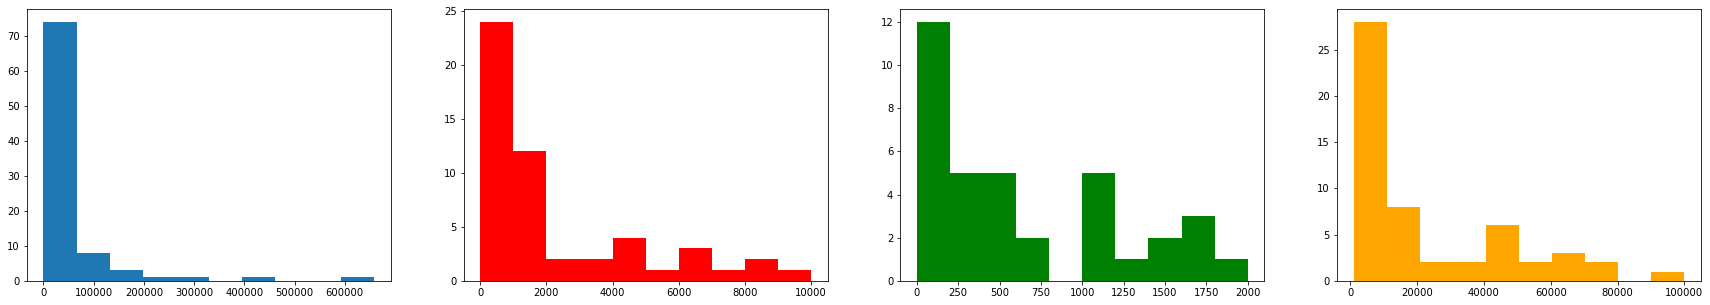

In [41]:
fig, axs = plt.subplots(1, 4, figsize = (30,5))
axs[0].hist(counts)
axs[1].hist(counts, range = [0, 10000], color = "red")
axs[2].hist(counts, range = [0, 2000], color = "green")
axs[3].hist(counts, range = [1000, 100000], color = "orange") # area of interest

In [33]:
# counts = all_userdata_df['Users'].value_counts()

# counts_parkinson = all_userdata_df[all_userdata_df["Parkinsons"] == "True"]
# counts_parkinsonf = all_userdata_df[all_userdata_df["Parkinsons"] == "False"]

# counts_parkinson.nunique()
# counts_parkinsonf.nunique()
# print(len(counts))
#siamo 48, 18 positivi 30 negativi

Vengono convertiti tutti i dati, da Object a Float (Hold e Latency), Int (BirthYear), Boolean (Gender e Parkinsons) per poter effettuare calcoli sui valori delle feature.

In [6]:
# convert and normalize

all_userdata_df.Hold = all_userdata_df.Hold.astype(float)

all_userdata_df.Latency = all_userdata_df.Latency.astype(float)

all_userdata_df.BirthYear = all_userdata_df.BirthYear.astype(int)
all_userdata_df.BirthYear = 2017 - all_userdata_df.BirthYear
all_userdata_df = all_userdata_df.rename(columns = {"BirthYear" : "Age"}) # in terms of ages

all_userdata_df.Gender.replace(['Male', 'Female'], [1, 0], inplace=True)

all_userdata_df.Parkinsons.replace(['True', 'False'], [1, 0], inplace=True)

In [5]:
all_userdata_df.head()

,Users,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,0QAZFRHQHW,L,78.1,LL,312.5,58,0,0
158454,0QAZFRHQHW,L,78.1,LL,453.1,58,0,0
158455,0QAZFRHQHW,L,62.5,LL,414.1,58,0,0
158456,0QAZFRHQHW,L,93.8,LL,742.2,58,0,0
158457,0QAZFRHQHW,R,101.6,LR,523.4,58,0,0


In [26]:
print(all_userdata_df["Hold"])

158453      78.1
158454      78.1
158455      62.5
158456      93.8
158457     101.6
           ...  
8663133    109.4
8663134    125.0
8663135    171.9
8663136    132.8
8663137    109.4
Name: Hold, Length: 1055475, dtype: float64


#### Individuazione e rimozione degli outliers
Ci sono valori anomali delle feature Hold e Latency. Questi vengono rimossi, mantenendo i punti che hanno un valore di deviazione standard inferiore a 3.

In [7]:
hold_z_scores = stats.zscore(all_userdata_df["Hold"])
abs_z_scores = np.abs(hold_z_scores)
filtered_entries = (abs_z_scores < 3)
all_userdata_df = all_userdata_df[filtered_entries]

lat_z_scores = stats.zscore(all_userdata_df["Latency"])
abs_z_scores = np.abs(lat_z_scores)
filtered_entries2 = (abs_z_scores < 3)
all_userdata_df = all_userdata_df[filtered_entries2]

all_userdata_df.head(10)

,Users,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,0QAZFRHQHW,L,78.1,LL,312.5,58,0,0
158454,0QAZFRHQHW,L,78.1,LL,453.1,58,0,0
158455,0QAZFRHQHW,L,62.5,LL,414.1,58,0,0
158457,0QAZFRHQHW,R,101.6,LR,523.4,58,0,0
158458,0QAZFRHQHW,R,93.8,RR,203.1,58,0,0
158459,0QAZFRHQHW,L,109.4,RL,289.1,58,0,0
158460,0QAZFRHQHW,R,214.8,LR,316.4,58,0,0
158461,0QAZFRHQHW,R,66.4,RR,382.8,58,0,0
158462,0QAZFRHQHW,L,93.8,RL,562.5,58,0,0
158463,0QAZFRHQHW,R,187.5,RR,453.1,58,0,0


Vengono calcolate media, deviazione standard, skewness e kurtosis, per ogni utente, per la feature TapPosition (escludendo i tap con valore S, in quanto non aggiunge informazione) usando i tempi di Hold.
Poi viene fatta la stessa cosa per la feature Movement, rispetto ai tempi di Latency (anche qui non si considerano i valori contenenti S).

I due dataset ottenuti vengono concatenati per ottenere *combined_df*.

In [8]:
hold_by_user =  all_userdata_df[all_userdata_df['TapPosition'] != 'S'].groupby(['Users', 'TapPosition'])['Hold'].agg([np.mean, np.std, skew, kurtosis])
hold_by_user.head(10)

mean        std      skew    kurtosis
Users      TapPosition                                             
0QAZFRHQHW L             98.240728  23.645192  0.162026    0.809259
           R            100.893509  36.764586  8.381640  126.796559
1XNJCXS3EY L            153.702407  53.213749  0.264109    0.605739
           R            105.622423  27.036622  2.790381   23.913747
3DIXPRIOSW L            147.733913  48.299987  0.705847    0.625965
           R            167.174157  56.074955  0.015762    0.243456
48DZPAJ5NS L            125.093648  21.344768  0.433347    5.116874
           R            125.944823  20.440962  0.122130    5.692705
5PQVTWULAC L            131.600807  37.119034  0.968724    7.255120
           R            113.511765  28.851806 -0.031928    0.777919

In [9]:
hold_by_user_flat = hold_by_user.unstack()
hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]
hold_by_user_flat['mean_hold_diff'] = hold_by_user_flat['mean_L'] - hold_by_user_flat['mean_R']
hold_by_user_flat.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff
Users,,,,,,,,,
0QAZFRHQHW,98.240728,100.893509,23.645192,36.764586,0.162026,8.381640,0.809259,126.796559,-2.652781
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984
3DIXPRIOSW,147.733913,167.174157,48.299987,56.074955,0.705847,0.015762,0.625965,0.243456,-19.440244
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175
5PQVTWULAC,131.600807,113.511765,37.119034,28.851806,0.968724,-0.031928,7.255120,0.777919,18.089043


In [10]:
latency_by_user = all_userdata_df[np.isin(all_userdata_df['Movement'], ['LL', 'LR', 'RL', 'RR'])].groupby(['Users', 'Movement'])['Latency'].agg([np.mean, np.std, skew, kurtosis])
latency_by_user.head(10)

mean         std      skew  kurtosis
Users      Movement                                            
0QAZFRHQHW LL        381.513699  138.685633  0.100358 -0.852940
           LR        370.189302  166.356770  0.199686 -1.147631
           RL        385.640196  143.653008  0.127575 -1.000993
           RR        344.055417  132.589072  0.328537 -0.522270
1XNJCXS3EY LL        347.882547  101.977747 -1.332784  1.946994
           LR        313.541489   97.680669  0.008248 -0.715397
           RL        310.799454   98.038127  0.037478 -0.723288
           RR        322.170833   82.901327 -0.284840  0.725222
3DIXPRIOSW LL        486.421516  110.525337 -0.654455  0.702029
           LR        496.948684  114.504608 -0.070632 -1.162515

In [11]:
latency_by_user_flat = latency_by_user.unstack()
latency_by_user_flat.columns = ['_'.join(col).strip() for col in latency_by_user_flat.columns.values]
latency_by_user_flat['mean_LR_RL_diff'] = latency_by_user_flat['mean_LR'] - latency_by_user_flat['mean_RL']
latency_by_user_flat['mean_LL_RR_diff'] = latency_by_user_flat['mean_LL'] - latency_by_user_flat['mean_RR']
latency_by_user_flat.head()

,mean_LL,mean_LR,mean_RL,mean_RR,std_LL,std_LR,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff
Users,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,381.513699,370.189302,385.640196,344.055417,138.685633,166.356770,143.653008,132.589072,0.100358,0.199686,0.127575,0.328537,-0.852940,-1.147631,-1.000993,-0.522270,-15.450894,37.458282
1XNJCXS3EY,347.882547,313.541489,310.799454,322.170833,101.977747,97.680669,98.038127,82.901327,-1.332784,0.008248,0.037478,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714
3DIXPRIOSW,486.421516,496.948684,458.456098,454.361497,110.525337,114.504608,108.730466,138.325691,-0.654455,-0.070632,0.172017,-0.842368,0.702029,-1.162515,-0.750796,0.818784,38.492587,32.060019
48DZPAJ5NS,300.190663,335.274126,321.053098,332.504906,81.809939,81.450453,88.512695,90.989458,0.361579,0.020670,0.143658,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242
5PQVTWULAC,347.886933,461.184922,429.867896,369.359147,105.043167,114.216291,110.960993,121.075534,0.471543,-0.290666,-0.029059,0.348485,1.542700,-0.364315,0.016987,0.084734,31.317026,-21.472215


In [12]:
combined_df = pd.concat([hold_by_user_flat, latency_by_user_flat], axis = 1)
combined_df.shape

(48, 27)

In [13]:
combined_df.head(10)

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff,mean_LL,...,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff
Users,,,,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,98.240728,100.893509,23.645192,36.764586,0.162026,8.381640,0.809259,126.796559,-2.652781,381.513699,...,0.100358,0.199686,0.127575,0.328537,-0.852940,-1.147631,-1.000993,-0.522270,-15.450894,37.458282
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984,347.882547,...,-1.332784,0.008248,0.037478,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714
3DIXPRIOSW,147.733913,167.174157,48.299987,56.074955,0.705847,0.015762,0.625965,0.243456,-19.440244,486.421516,...,-0.654455,-0.070632,0.172017,-0.842368,0.702029,-1.162515,-0.750796,0.818784,38.492587,32.060019
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175,300.190663,...,0.361579,0.020670,0.143658,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242
5PQVTWULAC,131.600807,113.511765,37.119034,28.851806,0.968724,-0.031928,7.255120,0.777919,18.089043,347.886933,...,0.471543,-0.290666,-0.029059,0.348485,1.542700,-0.364315,0.016987,0.084734,31.317026,-21.472215
5USOYSDCXB,72.132413,74.700316,26.086367,23.767150,0.137379,-0.266666,0.876562,1.673804,-2.567903,176.594900,...,1.478618,2.742424,2.561329,1.017373,5.831759,11.392096,9.168778,4.921522,-5.478959,0.510273
6LB9FQABZQ,126.335480,98.195346,67.057993,48.690887,0.272691,0.066486,0.012373,0.668249,28.140134,182.003481,...,1.620432,1.690018,2.393288,1.767309,2.897400,2.460193,6.603472,3.708822,31.932386,1.058386
8O9IAIA9L1,86.245949,98.157840,32.187330,36.925520,0.916510,0.705804,2.928178,2.228437,-11.911891,212.208236,...,1.516547,1.896938,1.735821,1.744931,4.373889,4.284598,4.601540,3.747598,2.830375,1.534293
9RCEHVGNCJ,122.133756,121.121119,67.125722,31.941490,-0.084666,-0.702247,-0.831288,1.680434,1.012637,273.797307,...,0.571781,1.740022,1.348257,0.768452,0.135852,2.998323,2.673936,0.591929,-26.263819,-7.457911


*all_userdata_df* e *combined_df* vengono uniti per creare *complete_df*, costituito da tutti i valori statistici calcolati per le vecchie feature TapPosition e Movement, oltre alle feature Age, Gender e Parkinsons.

In [15]:
all_userdata_df = all_userdata_df.drop(["TapPosition", "Hold", "Latency", "Movement"], axis=1)
all_userdata_df = all_userdata_df.drop_duplicates()
# combined_df.set_index('Users', inplace = True)
# complete_df = combined_df.merge(all_userdata_df[["Users", "Age", "Gender", "Parkinsons"]], how="left", on=["Users"], indicator = True)
# combined_df.set_index('Users', inplace = True)
# all_userdata_df.set_index('Users', inplace = True)
#complete_df = pd.merge(combined_df, all_userdata_df_dropped, how='left', left_on = 'Users', right_on = 'Users')
# complete_df.shape
#complete_df.head(10)

complete_df = combined_df.merge(all_userdata_df, how='left', left_on = 'Users', right_on = 'Users')
complete_df.head()

,Users,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff,...,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff,Age,Gender,Parkinsons
0,0QAZFRHQHW,98.240728,100.893509,23.645192,36.764586,0.162026,8.381640,0.809259,126.796559,-2.652781,...,0.328537,-0.852940,-1.147631,-1.000993,-0.522270,-15.450894,37.458282,58,0,0
1,1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984,...,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714,81,1,0
2,3DIXPRIOSW,147.733913,167.174157,48.299987,56.074955,0.705847,0.015762,0.625965,0.243456,-19.440244,...,-0.842368,0.702029,-1.162515,-0.750796,0.818784,38.492587,32.060019,81,1,0
3,48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175,...,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242,67,1,1
4,5PQVTWULAC,131.600807,113.511765,37.119034,28.851806,0.968724,-0.031928,7.255120,0.777919,18.089043,...,0.348485,1.542700,-0.364315,0.016987,0.084734,31.317026,-21.472215,74,0,1


#### Istogrammi per *complete_df*
Tutte le feature vengono graficate con i seguenti istogrammi.

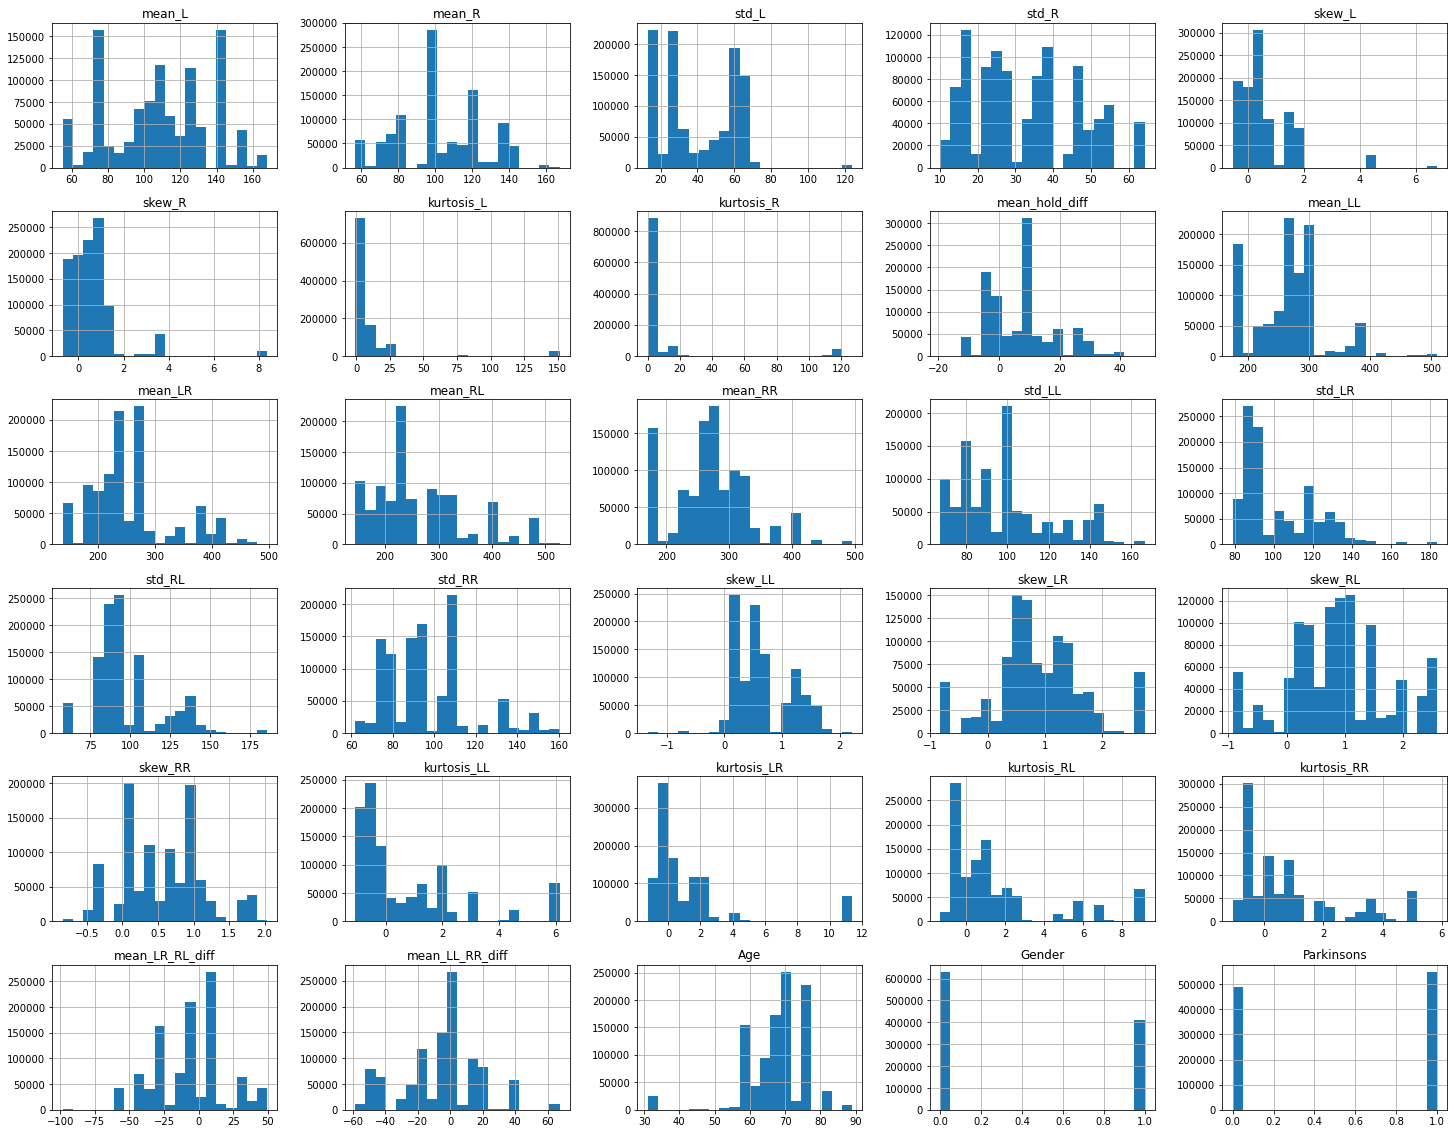

In [18]:
complete_df.hist(bins=20, figsize=(25, 20))
plt.show()

Prima versione: normalizzazione e conversione delle feature. Nella seconda versione questa cella non viene eseguita.

In [42]:
# le colonne ora sono: tap position (L/R), Hold, Movement, BirthYear, Gender, Parkinsons (T/F)
# rimuovo gli utenti senza data di nascita, perche mi serve per calcolare l'eta


# normalizzazione
# L/R - Gender - Parkinson : devono diventare campi binari del tipo 0/1
# movement : lo codifichiamo con onehot dividendolo in 4 colonne
# latency - hold : sono dei float
# age (ottenuta da 2017 - birthyear) : int

# all_userdata_df.TapPosition.replace(['R', 'L', 'S'], [0, 1, 2], inplace = True)

# all_userdata_df.Movement.replace(['LL', 'LR', 'RR', 'RL', 'LS', 'SL', 'RS', 'SR', 'SS'], [0, 1, 2, 3, 4, 5, 6, 7, 8], inplace = True)

# all_userdata_df.head()

,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,1,78.1,0,312.5,58,0,0
158454,1,78.1,0,453.1,58,0,0
158455,1,62.5,0,414.1,58,0,0
158456,1,93.8,0,742.2,58,0,0
158457,0,101.6,1,523.4,58,0,0


Prima versione: OneHot encoding delle feature TapPosition e Movement. Nella seconda versione questa cella non viene eseguita

In [43]:
# onehot di tap position e movement

# OneHotTapPosition = pd.get_dummies(all_userdata_df.TapPosition)
# OneHotMovement = pd.get_dummies(all_userdata_df.Movement)

# OneHotMovement = OneHotMovement.rename(columns = {0: "LL", 1: "LR", 2: "RR", 3: "RL", 4: "LS", 5: "SL", 6: "RS", 7: "SR", 8: "SS"})
# all_userdata_df = all_userdata_df.drop(["Movement"], axis=1)

# OneHotTapPosition = OneHotTapPosition.rename(columns = {0: "TapR", 1: "TapL", 2: "TapS"})
# all_userdata_df = all_userdata_df.drop(["TapPosition"], axis=1)

# all_userdata_df = pd.concat([all_userdata_df, OneHotTapPosition, OneHotMovement], axis=1)

In [44]:
# all_userdata_df = all_userdata_df.reindex(columns = ["Age", "Hold", "Latency", "Gender", "TapR", "TapL", "LL", "LR", "RR", "RL", "LS", "SL", "RS", "SR", "SS", "Parkinsons"])


# all_userdata_df.head(20)

,Age,Hold,Latency,Gender,TapR,TapL,LL,LR,RR,RL,LS,SL,RS,SR,SS,Parkinsons
158453,58,78.1,312.5,0,0,1,1,0,0,0,0,0,0,0,0,0
158454,58,78.1,453.1,0,0,1,1,0,0,0,0,0,0,0,0,0
158455,58,62.5,414.1,0,0,1,1,0,0,0,0,0,0,0,0,0
158456,58,93.8,742.2,0,0,1,1,0,0,0,0,0,0,0,0,0
158457,58,101.6,523.4,0,1,0,0,1,0,0,0,0,0,0,0,0
158458,58,93.8,203.1,0,1,0,0,0,1,0,0,0,0,0,0,0
158459,58,109.4,289.1,0,0,1,0,0,0,1,0,0,0,0,0,0
158460,58,214.8,316.4,0,1,0,0,1,0,0,0,0,0,0,0,0
158461,58,66.4,382.8,0,1,0,0,0,1,0,0,0,0,0,0,0
158462,58,93.8,562.5,0,0,1,0,0,0,1,0,0,0,0,0,0


Pie plot per i pazienti con e senza morbo di Parkinson.

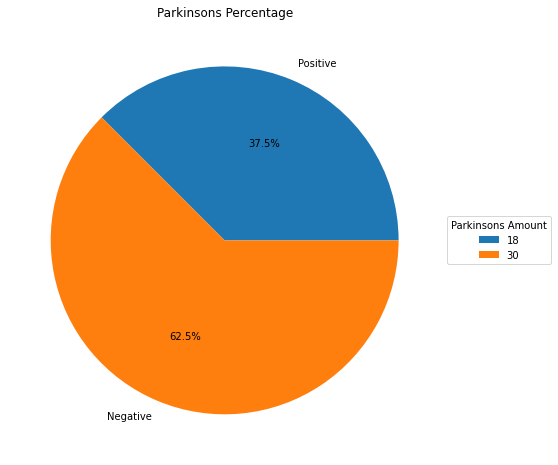

In [16]:
total_rows = complete_df.shape
counts_parkinson = complete_df[complete_df["Parkinsons"] == 1].shape

x = np.array([counts_parkinson[0], total_rows[0]-counts_parkinson[0]])
label = ["Positive", "Negative"]
plt.figure(figsize=(8,8), facecolor = "white")

plt.pie(x, labels = label, autopct='%1.1f%%')
plt.title("Parkinsons Percentage")
plt.legend(x, title="Parkinsons Amount", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Il dataset è leggermente sbilanciato, con una quantità maggiore di pazienti negativi. Per questo verrà effettuato un oversampling attraverso l'utilizzo della tecnica SMOTE.

In [19]:

# # all_userdata_df.hist(bins = 10, figsize = (20,15), range = [0, 500])
# fig, axs = plt.subplots(1, 5, figsize = (30,5))

# axs[2].hist(all_userdata_df.Hold)
# axs[2].set_title('Hold')
# axs[3].hist(all_userdata_df.Latency)
# axs[3].set_title('Latency')
# axs[1].hist(all_userdata_df.Gender, color = "red")
# axs[1].set_title('Gender')
# axs[0].hist(all_userdata_df.Age)
# axs[0].set_title('Age')
# axs[4].hist(all_userdata_df.Parkinsons, color = "red")
# axs[4].set_title('Parkinsons')

# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==812648.4].index, inplace=True)
# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==84773.4].index, inplace=True)
# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==4480.5].index, inplace=True)

# # find = all_userdata_df[all_userdata_df.Hold > 3000]
# # print(find)
complete_df.set_index('Users', inplace = True)

complete_df.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff,mean_LL,...,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff,Age,Gender,Parkinsons
Users,,,,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,98.240728,100.893509,23.645192,36.764586,0.162026,8.381640,0.809259,126.796559,-2.652781,381.513699,...,0.328537,-0.852940,-1.147631,-1.000993,-0.522270,-15.450894,37.458282,58,0,0
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984,347.882547,...,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714,81,1,0
3DIXPRIOSW,147.733913,167.174157,48.299987,56.074955,0.705847,0.015762,0.625965,0.243456,-19.440244,486.421516,...,-0.842368,0.702029,-1.162515,-0.750796,0.818784,38.492587,32.060019,81,1,0
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175,300.190663,...,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242,67,1,1
5PQVTWULAC,131.600807,113.511765,37.119034,28.851806,0.968724,-0.031928,7.255120,0.777919,18.089043,347.886933,...,0.348485,1.542700,-0.364315,0.016987,0.084734,31.317026,-21.472215,74,0,1


### Preprocessing

#### Train and test
Si suddividono tutte le feature dal target, rappresentato dall'attributo Parkinsons.
Poi divido la matrice x e l'array y in sottoinsiemi casuali sfruttando la funzione *train_test_split*.

In [21]:
x = complete_df.iloc[:, :-1].values
y = complete_df.iloc[:, -1].values  # Parkinsons column

print(x)
print(y)

# split x matrix and y array in random train and test subsets, with ratio 3/4 - 1/4
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

[[ 98.2407279  100.89350913  23.64519173 ...  37.45828196  58.
    0.        ]
 [153.702407   105.62242315  53.21374903 ...  25.71171384  81.
    1.        ]
 [147.73391304 167.1741573   48.29998681 ...  32.06001857  81.
    1.        ]
 ...
 [101.62638772 113.74829833  44.00769261 ...  12.41033032  69.
    1.        ]
 [146.04592179 143.39524618  35.36990282 ... -25.67312141  89.
    1.        ]
 [131.02282292 122.02921979  64.96298389 ... -27.01565622  70.
    0.        ]]
[0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1
 1 0 1 0 1 0 1 0 0 0 1]


In [61]:
# graph = all_userdata_df.sample(n = 100)
# x_graph = graph.iloc[:, 1:3].values
# y_graph = graph.iloc[:, -1].values

# print(x_train)
# print(y_train)

# print(x_test)
# print(y_test)

# print(x_graph)
# print(y_graph)

In [41]:
# import collections
# print(len(y_train))
# new_parkinson = collections.Counter(y_train)[1]
# print(new_parkinson)

#### Scaling

Scalare i dati serve a migliorare il comportamento degli algoritmi di learning, dal momento che i dati potrebbero avere valori di tipi diversi tra loro. Valori troppo grandi possono comportarsi da outlier e stravolgere il funzionamento di un algoritmo.

Per scalare i dati si utilizza la normalizzazione attraverso lo *StandardScaler* offerto da sklearn.

In [23]:
# scaling before classification models
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# x_graph = scaler.fit_transform(x_graph)

In [43]:
# matrice di correlazione per curiosita

# import seaborn as sns
# corr = pd.concat([x, y], axis=1).corr()
# corr_values = corr.iloc[:,15].values
# print("Massima correlazione positiva con il target:", np.max(corr_values[0:corr_values.size-1]))
# print("Massima correlazione negativa con il target:", np.min(corr_values))
# print(pd.concat([x, y], axis=1).columns[abs(corr_values) < 0.01]) 

# plt.figure(figsize=(15, 16), dpi=160)
# sns.heatmap(pd.concat([x, y], axis=1).corr(), cmap="bwr")


#### Bilanciamento
Come già detto, il dataset risulta sbilanciato rispetto al target: il 62.5% delle osservazioni sono etichettate con 0 ('Negativo') mentre il 37.5% con 1 ('Positivo').

SMOTE (Synthetic Minority Oversampling Technique): serve ad aumentare la dimensione della classe minoritaria creando dati sintetici, creati in base a formule e algoritmi di clustering sui dati presenti.

In [24]:
smote = SMOTE(random_state=0, sampling_strategy='not majority', k_neighbors=5, n_jobs=-1)

x_train, y_train = smote.fit_resample(x_train, y_train)
print(x_train.shape, y_train.shape)
print(x_train)

(44, 29) (44,)
[[-1.25307902 -1.47173785 -0.05042894 ... -1.52719806  0.24588388
   0.9459053 ]
 [-0.90791957 -1.00013427 -0.81345849 ... -1.62774095 -2.62707519
   0.9459053 ]
 [ 0.19500789  0.04125402  0.65359457 ...  0.10491963  0.01294126
  -1.05718828]
 ...
 [ 0.14724022 -0.09931525  0.14699352 ...  0.21054019  0.01294126
  -0.09574909]
 [ 0.13000632 -0.06375751 -0.41914694 ... -0.78199994  0.53157771
  -0.27040358]
 [-0.96914701 -1.18303641 -0.06941253 ... -1.33491273  0.33498045
   0.9459053 ]]


[1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1
 1 1 1 1 1 1 1]


(array([22.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

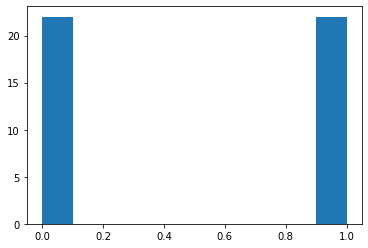

In [25]:
# verify that the classes are balanced
print(y_train)
np.histogram(y_train)
plt.hist(y_train)

### Classificazione

#### Naive Bayes

0.782608695652174
0.75


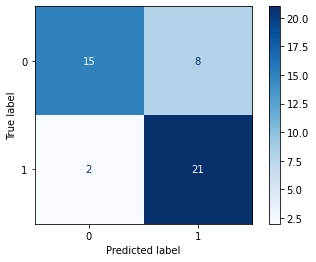

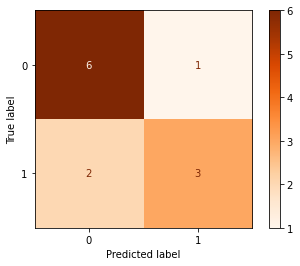

In [82]:
# Naive Bayes classification
classifierBAYES = GaussianNB()
classifierBAYES.fit(x_train, y_train)

y_pred_BAYES0 = classifierBAYES.predict(x_train)
y_pred_BAYES = classifierBAYES.predict(x_test)

CM_BAYES0 = confusion_matrix(y_train, y_pred_BAYES0)
PercBAYES0 = (CM_BAYES0[0,0]+CM_BAYES0[1,1])/CM_BAYES0.sum()

CM_BAYES = confusion_matrix(y_test, y_pred_BAYES)
PercBAYES = (CM_BAYES[0,0]+CM_BAYES[1,1])/CM_BAYES.sum()

cmd0 = ConfusionMatrixDisplay(CM_BAYES0)
cmd = ConfusionMatrixDisplay(CM_BAYES)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercBAYES0)
print(PercBAYES)

#### Logistic Regression

0.9130434782608695
0.4166666666666667


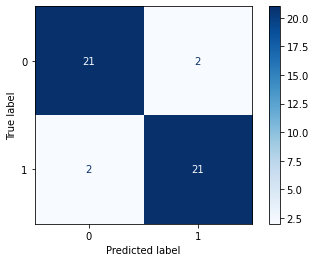

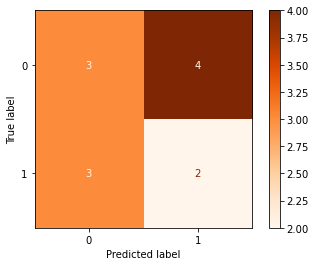

In [83]:

# qua si parte con il learning
# pero il ragazzo di Genova dice che x_train e x_test hanno troppe righe
# allora si riduce le dimensioni del dataset prendendo il 4% (applica test_size = 0.2 per due volte)

#############


classifierLogReg = LogisticRegression(random_state = 0)
classifierLogReg.fit(x_train, y_train)

#The algorithm has learnt on training set, now I will predict the outcomes on test set
y_pred_LogReg0 = classifierLogReg.predict(x_train)
y_pred_LogReg = classifierLogReg.predict(x_test)

# ogni riga e un'istanza della classe vera
# e la matrice TP FP TN FN
CM_LogReg0 = confusion_matrix(y_train, y_pred_LogReg0)
PercLogReg0 = (CM_LogReg0[0,0]+CM_LogReg0[1,1])/CM_LogReg0.sum()

CM_LogReg = confusion_matrix(y_test, y_pred_LogReg)
PercLogReg = (CM_LogReg[0,0]+CM_LogReg[1,1])/CM_LogReg.sum()
# print(CM_LogReg)
# print(CM_LogReg0)

# print(PercLogReg)
# print(PercLogReg0)

cmd0 = ConfusionMatrixDisplay(CM_LogReg0)
cmd = ConfusionMatrixDisplay(CM_LogReg)

cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercLogReg0)
print(PercLogReg)

#visual
# from matplotlib.colors import ListedColormap

# classifierLogReg_graph = LogisticRegression(random_state = 0)
# classifierLogReg_graph.fit(x_graph, y_graph)

# X_set, y_set = x_graph, y_graph
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
#                      np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
# plt.figure(1)
# plt.contourf(X1, X2, classifierLogReg_graph.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
#                 c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('Logistic Regression')
# plt.xlabel('Latency')
# plt.ylabel('Hold')
# plt.legend()
# plt.show()




#### Decision Tree

1.0
0.6666666666666666


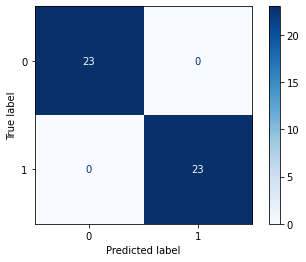

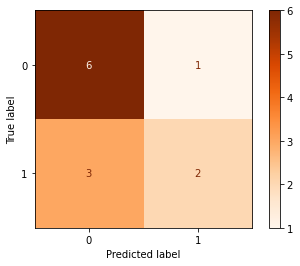

In [84]:
# Decision Tree classification

classifierTREE = DecisionTreeClassifier(criterion = 'entropy', splitter = "best", max_depth = 5, random_state = 0)
classifierTREE.fit(x_train, y_train)

# provare la profondita e capire perche

y_pred_TREE = classifierTREE.predict(x_test)
y_pred_TREE0 = classifierTREE.predict(x_train)

CM_TREE0 = confusion_matrix(y_train, y_pred_TREE0)
PercTREE0 = (CM_TREE0[0,0]+CM_TREE0[1,1])/CM_TREE0.sum()

CM_TREE = confusion_matrix(y_test, y_pred_TREE)
PercTREE = (CM_TREE[0,0]+CM_TREE[1,1])/CM_TREE.sum()

cmd0 = ConfusionMatrixDisplay(CM_TREE0)
cmd = ConfusionMatrixDisplay(CM_TREE)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercTREE0)
print(PercTREE)


#### Random Forest

1.0
0.75


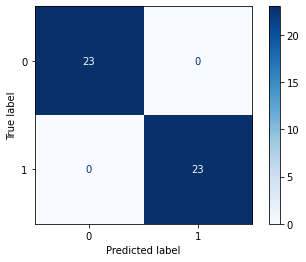

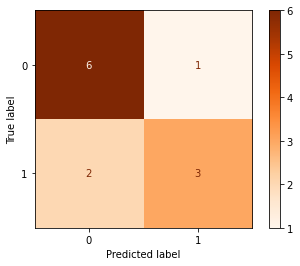

In [85]:
# Random Forest classification

classifierFOR = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierFOR.fit(x_train, y_train)

y_pred_FOR0 = classifierFOR.predict(x_train)
y_pred_FOR = classifierFOR.predict(x_test)

CM_FOR0 = confusion_matrix(y_train, y_pred_FOR0)
PercFOR0 = (CM_FOR0[0,0]+CM_FOR0[1,1])/CM_FOR0.sum()

CM_FOR = confusion_matrix(y_test, y_pred_FOR)
PercFOR = (CM_FOR[0,0]+CM_FOR[1,1])/CM_FOR.sum()

cmd0 = ConfusionMatrixDisplay(CM_FOR0)
cmd = ConfusionMatrixDisplay(CM_FOR)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercFOR0)
print(PercFOR)

#### Diminuzione della dimensione del dataset

In [52]:
# DIMINUIRE LA CARDINALITA DEL DATASET
x_train, x_test, y_train, y_test = train_test_split(x_test, y_test, test_size = 0.2)
x_train, x_test, y_train, y_test = train_test_split(x_test, y_test, test_size = 0.2)

#### Decision Tree dopo il taglio

0.8299867043943682
0.8358331060812654


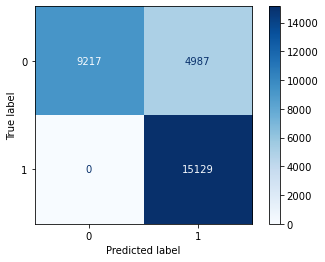

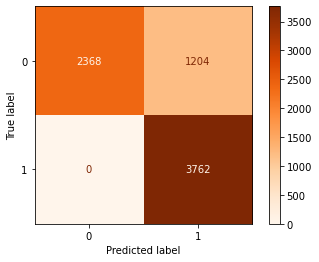

In [50]:
# Decision Tree classification

classifierTREE = DecisionTreeClassifier(criterion = 'entropy', splitter = "best", max_depth = 5, random_state = 0)
classifierTREE.fit(x_train, y_train)

y_pred_TREE = classifierTREE.predict(x_test)
y_pred_TREE0 = classifierTREE.predict(x_train)

CM_TREE0 = confusion_matrix(y_train, y_pred_TREE0)
PercTREE0 = (CM_TREE0[0,0]+CM_TREE0[1,1])/CM_TREE0.sum()

CM_TREE = confusion_matrix(y_test, y_pred_TREE)
PercTREE = (CM_TREE[0,0]+CM_TREE[1,1])/CM_TREE.sum()

cmd0 = ConfusionMatrixDisplay(CM_TREE0)
cmd = ConfusionMatrixDisplay(CM_TREE)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercTREE0)
print(PercTREE)

#### Random Forest dopo il taglio

0.9869771247400538
0.9196891191709845


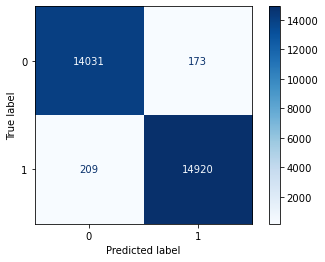

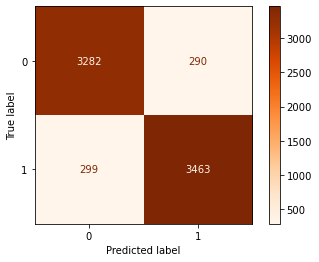

In [51]:
# Random Forest classification

classifierFOR = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierFOR.fit(x_train, y_train)

y_pred_FOR0 = classifierFOR.predict(x_train)
y_pred_FOR = classifierFOR.predict(x_test)

CM_FOR0 = confusion_matrix(y_train, y_pred_FOR0)
PercFOR0 = (CM_FOR0[0,0]+CM_FOR0[1,1])/CM_FOR0.sum()

CM_FOR = confusion_matrix(y_test, y_pred_FOR)
PercFOR = (CM_FOR[0,0]+CM_FOR[1,1])/CM_FOR.sum()

cmd0 = ConfusionMatrixDisplay(CM_FOR0)
cmd = ConfusionMatrixDisplay(CM_FOR)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercFOR0)
print(PercFOR)

#### Multilayer Perceptron

0.782608695652174
0.75


c:\Users\tagli\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


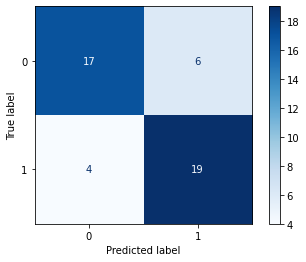

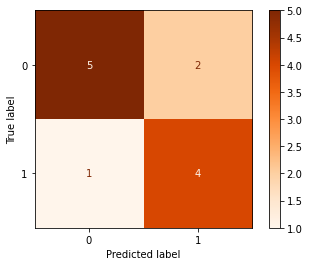

In [86]:
# Multiple Layer Perceptron

classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "relu", max_iter=50) # relu act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "tanh", max_iter=50) # tanh act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "identity", max_iter=50) # identity act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "logistic", max_iter=50) # logistic act

classifierMLPr.fit(x_train, y_train)

y_pred_MLPr0 = classifierMLPr.predict(x_train)
y_pred_MLPr = classifierMLPr.predict(x_test)

CM_MLPr0 = confusion_matrix(y_train, y_pred_MLPr0)
PercMLPr0 = (CM_MLPr0[0,0] + CM_MLPr0[1,1])/CM_MLPr0.sum()

CM_MLPr = confusion_matrix(y_test, y_pred_MLPr)
PercMLPr = (CM_MLPr[0,0] + CM_MLPr[1,1])/CM_MLPr.sum()

cmd0 = ConfusionMatrixDisplay(CM_MLPr0)
cmd = ConfusionMatrixDisplay(CM_MLPr)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercMLPr0)
print(PercMLPr)

#### Adaboost v1

In [87]:
# Adaboost v1

classifierADA = AdaBoostClassifier()

grid = dict()
grid['n_estimators'] = [200]
grid['learning_rate'] = [.001, .01, .1, 1]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# define the grid search procedure
grid_search = GridSearchCV(estimator = classifierADA, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(x_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_ , grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.773333 using {'learning_rate': 0.001, 'n_estimators': 200}
0.773333 (0.193103) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.771667 (0.213574) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.705000 (0.188569) with: {'learning_rate': 0.1, 'n_estimators': 200}
0.735000 (0.180808) with: {'learning_rate': 1, 'n_estimators': 200}


#### Adaboost v2

1.0
0.5


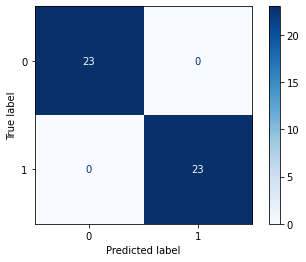

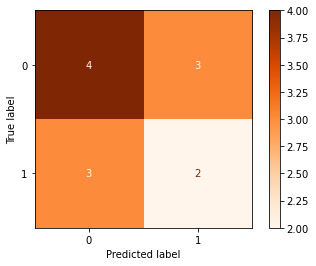

In [88]:
# ADABOOST v2

classifierAB = AdaBoostClassifier()
classifierAB.fit(x_train, y_train)

y_pred_AB0 = classifierAB.predict(x_train)
y_pred_AB = classifierAB.predict(x_test)

CM_AB0 = confusion_matrix(y_train, y_pred_AB0)
PercAB0 = (CM_AB0[0,0] + CM_AB0[1,1])/CM_AB0.sum()

CM_AB = confusion_matrix(y_test, y_pred_AB)
PercAB = (CM_AB[0,0] + CM_AB[1,1])/CM_AB.sum()

cmd0 = ConfusionMatrixDisplay(CM_AB0)
cmd = ConfusionMatrixDisplay(CM_AB)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercAB0)
print(PercAB)

#### SVM

0.9130434782608695
0.6666666666666666


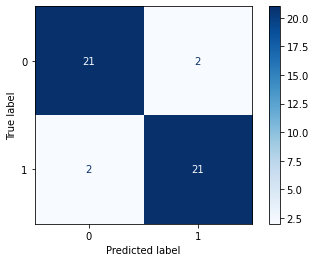

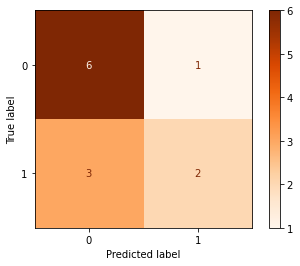

In [89]:
# SVM to fit algorithm

classifierSVC = SVC(kernel = 'rbf', random_state = 0)
classifierSVC.fit(x_train, y_train)

y_pred_SVMK0 = classifierSVC.predict(x_train)
y_pred_SVMK = classifierSVC.predict(x_test)

CM_SVMK0 = confusion_matrix(y_train, y_pred_SVMK0)
PercSVMK0 = (CM_SVMK0[0,0]+CM_SVMK0[1,1])/CM_SVMK0.sum()

CM_SVMK = confusion_matrix(y_test, y_pred_SVMK)
PercSVMK = (CM_SVMK[0,0]+CM_SVMK[1,1])/CM_SVMK.sum()

cmd0 = ConfusionMatrixDisplay(CM_SVMK0)
cmd = ConfusionMatrixDisplay(CM_SVMK)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercSVMK0)
print(PercSVMK)

#### K-Nearest Neighbors

0.782608695652174
0.6666666666666666


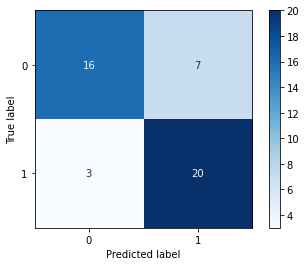

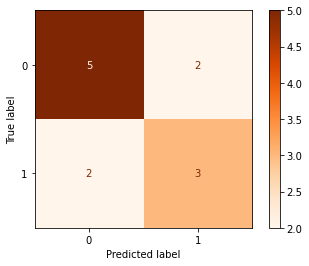

In [90]:
# KNN to fit algorithm

classifierKNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifierKNN.fit(x_train, y_train)

y_pred_KNN0 = classifierKNN.predict(x_train)
y_pred_KNN = classifierKNN.predict(x_test)

CM_KNN0 = confusion_matrix(y_train, y_pred_KNN0)
PercKNN0 = (CM_KNN0[0,0]+CM_KNN0[1,1])/CM_KNN0.sum()

CM_KNN = confusion_matrix(y_test, y_pred_KNN)
PercKNN = (CM_KNN[0,0]+CM_KNN[1,1])/CM_KNN.sum()

cmd0 = ConfusionMatrixDisplay(CM_KNN0)
cmd = ConfusionMatrixDisplay(CM_KNN)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercKNN0)
print(PercKNN)

#### Ensemble Voting

0.9130434782608695
0.75


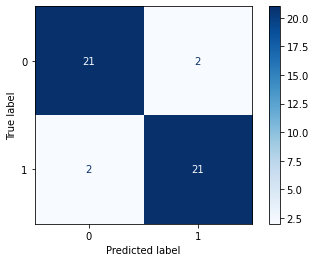

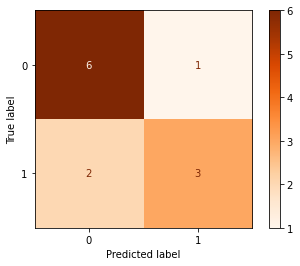

In [91]:
# Ensemble voting

Models = []
Models.append(('KNN', classifierKNN))
Models.append(('SVC', classifierSVC))
Models.append(('Tree', classifierTREE))
# Models.append(('Logistic', classifierLogReg))
# Models.append(('Bayes', classifierBAYES))

# by removing these last two classifiers, performances increase

ensemble = VotingClassifier(Models)
ensemble = ensemble.fit(x_train, y_train)

y_pred_ENS0 = ensemble.predict(x_train)
y_pred_ENS = ensemble.predict(x_test)

CM_ENS0 = confusion_matrix(y_train, y_pred_ENS0)
PercENS0 = (CM_ENS0[0,0]+CM_ENS0[1,1])/CM_ENS0.sum()

CM_ENS = confusion_matrix(y_test, y_pred_ENS)
PercENS = (CM_ENS[0,0]+CM_ENS[1,1])/CM_ENS.sum()

cmd0 = ConfusionMatrixDisplay(CM_ENS0)
cmd = ConfusionMatrixDisplay(CM_ENS)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercENS0)
print(PercENS)